In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split
import pandas as pd

In [6]:
df = pd.read_csv('/content/drive/MyDrive/IMDB Dataset.csv')

df['sentiment'] = df['sentiment'].map({'negative': 0, 'positive': 1})

In [7]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [8]:
def tokenize_text(text):
    return tokenizer.encode_plus(
        text,
        max_length=128,
        padding='max_length',
        truncation=True,
        return_tensors='tf'
    )

In [9]:
def convert_examples_to_features(texts, labels):
    input_ids = []
    attention_masks = []
    for text in texts:
        encoded_dict = tokenize_text(text)
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = tf.concat(input_ids, axis=0)
    attention_masks = tf.concat(attention_masks, axis=0)
    labels = tf.convert_to_tensor(labels)

    return {'input_ids': input_ids, 'attention_mask': attention_masks}, labels

In [10]:
train_data = convert_examples_to_features(train_df['review'], train_df['sentiment'])
test_data = convert_examples_to_features(test_df['review'], test_df['sentiment'])

In [11]:
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased')

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [13]:
from keras.callbacks import TensorBoard

In [14]:
board = TensorBoard(log_dir='./logs',histogram_freq=1)
model.fit(train_data[0], train_data[1], epochs=2,callbacks=[board])

Epoch 1/2


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1250/1250 [==============================] - 1034s 762ms/step - loss: 0.6988 - accuracy: 0.4988
Epoch 2/2
1250/1250 [==============================] - 959s 768ms/step - loss: 0.6935 - accuracy: 0.4987


In [15]:
eval_result = model.evaluate(test_data[0], test_data[1])
print("Test accuracy:", eval_result[1])

313/313 [==============================] - 94s 269ms/step - loss: 0.6931 - accuracy: 0.4961
Test accuracy: 0.4961000084877014


In [16]:
tf.saved_model.save(model, 'bert')

In [17]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109483778 (417.65 MB)
Trainable params: 109483778 (417.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


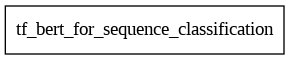

In [18]:
from keras.utils import plot_model
plot_model(model,to_file='bert.png')

In [23]:
predictions = model.predict(train_data[0])

predicted_class = tf.argmax(predictions[0], axis=1).numpy()[0]

1250/1250 [==============================] - 321s 256ms/step


In [24]:
if predicted_class == 0:
    print("Predicted sentiment: Negative")
else:
    print("Predicted sentiment: Positive")

Predicted sentiment: Negative
